<b> Understand the Problem: </b> The goal of this project is to predict a way ahead of Sentiment Analysis and to  determine the words in the tweet which decide the polarity of the tweet. And we will use the Jaccard score as evaluation metric. It is a measure of how similar/dissimilar two sets are.  The higher the score, the more similar the two strings. The idea is to find the number of common tokens and divide it by the total number of unique tokens.

Let's now begin with the Exploratory data analysis.
  

In [2]:
# Importing the libraries

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords


# Visualisation libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True)


# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# File system manangement
import os

#import spacy
from tqdm import tqdm
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

<b> Reading the datasets </b>

In [3]:
#Training data
train = pd.read_csv('twitter_sentiment_analysis/train.csv')
test = pd.read_csv('twitter_sentiment_analysis/test.csv')
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

# First few rows of the training dataset
train.head()

# First few rows of the testing dataset
test.head()

Training data shape:  (27481, 4)
Testing data shape:  (3534, 3)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


The columns denote the following:

* The `textID` of a tweet
* The `text` of a tweet
* The `selected text` which determines the polarity of the tweet
* `sentiment` of the tweet

The test dataset doesn't have the selected text column which needs to be identified.

<b> Exploratory Data Analysis</b>

In [4]:
#Missing values in training set
train.isnull().sum()
#Missing values in test set
test.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

textID       0
text         0
sentiment    0
dtype: int64

The `text` and `selected_text` column have one row missing each. Let's get rid of the missing rows.

In [5]:
# Dropping missing values
train.dropna(axis = 0, how ='any',inplace=True) ;
  

<b>Sentiment Column Analysis :</b> Now, let's analyse and see how the `Sentiment` column looks like. We have only used the training dataset but the process will remain the same if we wish to to do it for the test dataset as well.

Let's look at an example of each sentiment: Positive, negative and neutral

In [6]:
# Positive tweet
print("Positive Tweet example :",train[train['sentiment']=='positive']['text'].values[0])
#negative_text
print("Negative Tweet example :",train[train['sentiment']=='negative']['text'].values[0])
#neutral_text
print("Neutral tweet example  :",train[train['sentiment']=='neutral']['text'].values[0])

Positive Tweet example : 2am feedings for the baby are fun when he is all smiles and coos
Negative Tweet example :  Sooo SAD I will miss you here in San Diego!!!
Neutral tweet example  :  I`d have responded, if I were going


<b>Distribution of the Sentiment Column: </b>

In [7]:
train['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [8]:
#relative percentage
train['sentiment'].value_counts(normalize=True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

We can see about 40 percent of the tweets are neutral followed by positive and negative tweets. 

In [9]:
train['sentiment'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='red',
                                                      theme='pearl',
                                                      bargap=0.6,
                                                      gridcolor='white',
                                                     
                                                      title='Distribution of Sentiment column in the training set')

It would be interesting to see if the distribution is also same in the test set.

In [10]:
test['sentiment'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='red',
                                                      theme='pearl',
                                                      bargap=0.6,
                                                      gridcolor='white',
                                                      title='Distribution  of Sentiment column in the test set')

<b>Data Preprocessing :</b> Now we will pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. We will create a function which will perform the following tasks on the text columns: make text lowercase, removes hyperlinks,remove punctuation, removes numbers, tokenizes and removes stopwords.

In [11]:
# text preprocessing helper functions

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

`clean_text()` function applies a first round of text cleaning techniques.the function `text_preprocessing` then takes in the processed text from the `clean_text()` function and applies techniques like tokenization and stop word removal.

In [12]:
# Applying the cleaning function to both test and training datasets
train['text_clean'] = train['text'].apply(str).apply(lambda x: text_preprocessing(x))
test['text_clean'] = test['text'].apply(str).apply(lambda x: text_preprocessing(x))

In [13]:
train.head()

,textID,text,selected_text,sentiment,text_clean
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldnt they put them on the relea...


<b>Analyzing Text Statistics:</b> We can now do some statistical analysis to explore the fundamental characteristics of the text data. Some of the analysis which can be useful are: text length analysis and word frequency analysis.

To perform these analysis, let us create two new features, one which calculates the length of the text, and the other one calculates the word count.

In [14]:
train['text_len'] = train['text_clean'].astype(str).apply(len)
train['text_word_count'] = train['text_clean'].apply(lambda x: len(str(x).split()))

In [15]:
train.head()

,textID,text,selected_text,sentiment,text_clean,text_len,text_word_count
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going,33,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,42,10
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,22,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,29,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldnt they put them on the relea...,67,13


Let's create three separate dataframes for positive, neutral and negative sentiments. This will help in analyzing the text statistics separately for separate polarities.

In [16]:
pos = train[train['sentiment']=='positive']
neg = train[train['sentiment']=='negative']
neutral = train[train['sentiment']=='neutral']

<b> Sentence length analysis:</b>

In [17]:
pos['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Positive Text Length Distribution')

neg['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Negative Text Length Distribution')

neutral['text_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='Neutral Text Length Distribution')

The histogram shows that the length of the cleaned text ranges from around 2 to 140 characters and generally,it is almost same for all the polarities.


Let's see a more consolidated comparison of the relationship of text lengths with sentiment of the text.

In [18]:
trace0 = go.Box(
    y=pos['text_len'],
    name = 'Positive Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y=neg['text_len'],
    name = 'Negative Text',
    marker = dict(
        color = 'green',
    )
)

trace2 = go.Box(
    y=neutral['text_len'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "Length of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Length of the text of different polarities")

All the text appear to have more or less same length. Hence, length of the text isn't a powerful indicator of the polarity.

<b>Text word count analysis:</b>

In [19]:
pos['text_word_count'].iplot(
    kind='hist',
    bins=50,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Positive Text word count')

neg['text_word_count'].iplot(
    kind='hist',
    bins=50,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Negative Text word count')
neutral['text_word_count'].iplot(
    kind='hist',
    bins=50,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='Neutral Text word count')


Again, more or less, word count is also similar across positive, negative and neutral texts.This will be more clear with the Box Plots below.

In [20]:
trace0 = go.Box(
    y=pos['text_word_count'],
    name = 'Positive Text',
    marker = dict(
        color = 'red',
    )
)

trace1 = go.Box(
    y=neg['text_word_count'],
    name = 'Negative Text',
    marker = dict(
        color = 'green',
    )
)

trace2 = go.Box(
    y=neutral['text_word_count'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "word count of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "word count of the text of different polarities")

<b>N-gram exploration:</b> To analyse the `text` column we will be extracting the N-Gram features.N-grams are used to describe the number of words used as observation points. In order to do this, we will use scikit-learn’s CountVectorizer function. The Scikit-Learn's CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

In [21]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [22]:
# Distribution of top unigrams 

pos_unigrams = get_top_n_words(pos['text_clean'],20)
neg_unigrams = get_top_n_words(neg['text_clean'],20)
neutral_unigrams = get_top_n_words(neutral['text_clean'],20)

df1 = pd.DataFrame(pos_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Unigrams in positve text',orientation='h')

df2 = pd.DataFrame(neg_unigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', color='green',title='Top 20 Unigrams in negative text',orientation='h')

df3 = pd.DataFrame(neutral_unigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 Unigrams in neutral text',orientation='h')

In [23]:
# Distribution of top Bigrams

def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [24]:
pos_bigrams = get_top_n_gram(pos['text_clean'],(2,2),20)
neg_bigrams = get_top_n_gram(neg['text_clean'],(2,2),20)
neutral_bigrams = get_top_n_gram(neutral['text_clean'],(2,2),20)

df1 = pd.DataFrame(pos_bigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Bigrams in positve text',orientation='h')

df2 = pd.DataFrame(neg_bigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', color='green',title='Top 20 Bigrams in negative text',orientation='h')

df3 = pd.DataFrame(neutral_bigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 Bigrams in neutral text',orientation='h')

In [25]:
# Distribution of top Trigrams

pos_trigrams = get_top_n_gram(pos['text_clean'],(3,3),20)
neg_trigrams = get_top_n_gram(neg['text_clean'],(3,3),20)
neutral_trigrams = get_top_n_gram(neutral['text_clean'],(3,3),20)

df1 = pd.DataFrame(pos_trigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Trigrams in positve text',orientation='h')

df2 = pd.DataFrame(neg_trigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', color='green',title='Top 20 Trigrams in negative text',orientation='h')

df3 = pd.DataFrame(neutral_trigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 Trigrams in neutral text',orientation='h')

<b>Exploring the `selected_text` column </b>:

In [26]:
positive_text = train[train['sentiment'] == 'positive']['selected_text']
negative_text = train[train['sentiment'] == 'negative']['selected_text']
neutral_text = train[train['sentiment'] == 'neutral']['selected_text']

In [27]:
# Positive text

print("Positive Text example :",positive_text.values[0])

#negative_text
print("Negative Tweet example :",negative_text.values[0])

#neutral_text
print("Neutral tweet example  :",neutral_text.values[0])

Positive Text example : fun
Negative Tweet example : Sooo SAD
Neutral tweet example  : I`d have responded, if I were going


<b> Pre-processed selected text columns: </b>

In [28]:
positive_text_clean = positive_text.apply(lambda x: text_preprocessing(x))
negative_text_clean = negative_text.apply(lambda x: text_preprocessing(x))
neutral_text_clean = neutral_text.apply(lambda x: text_preprocessing(x))

In [29]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [30]:
top_words_in_positive_text = get_top_n_words(positive_text_clean)
top_words_in_negative_text = get_top_n_words(negative_text_clean)
top_words_in_neutral_text = get_top_n_words(neutral_text_clean)

p1 = [x[0] for x in top_words_in_positive_text[:20]]
p2 = [x[1] for x in top_words_in_positive_text[:20]]


n1 = [x[0] for x in top_words_in_negative_text[:20]]
n2 = [x[1] for x in top_words_in_negative_text[:20]]


nu1 = [x[0] for x in top_words_in_neutral_text[:20]]
nu2 = [x[1] for x in top_words_in_neutral_text[:20]]

In [32]:
import plotly.graph_objects as pg

fig = pg.Figure([go.Bar(x=p1, y=p2, text=p2 )])
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',title_text='Most common positive_text words')

fig1 = pg.Figure([go.Bar(x=n1, y=n2, text=n2,marker_color='indianred')])
fig1.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',title_text='Most common negative_text words')

fig2 = pg.Figure([go.Bar(x=nu1, y=nu2, text=nu2, marker_color='lightsalmon' )])
fig2.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',title_text='Most common neutral_text words')

<B>Wordclouds:</B>

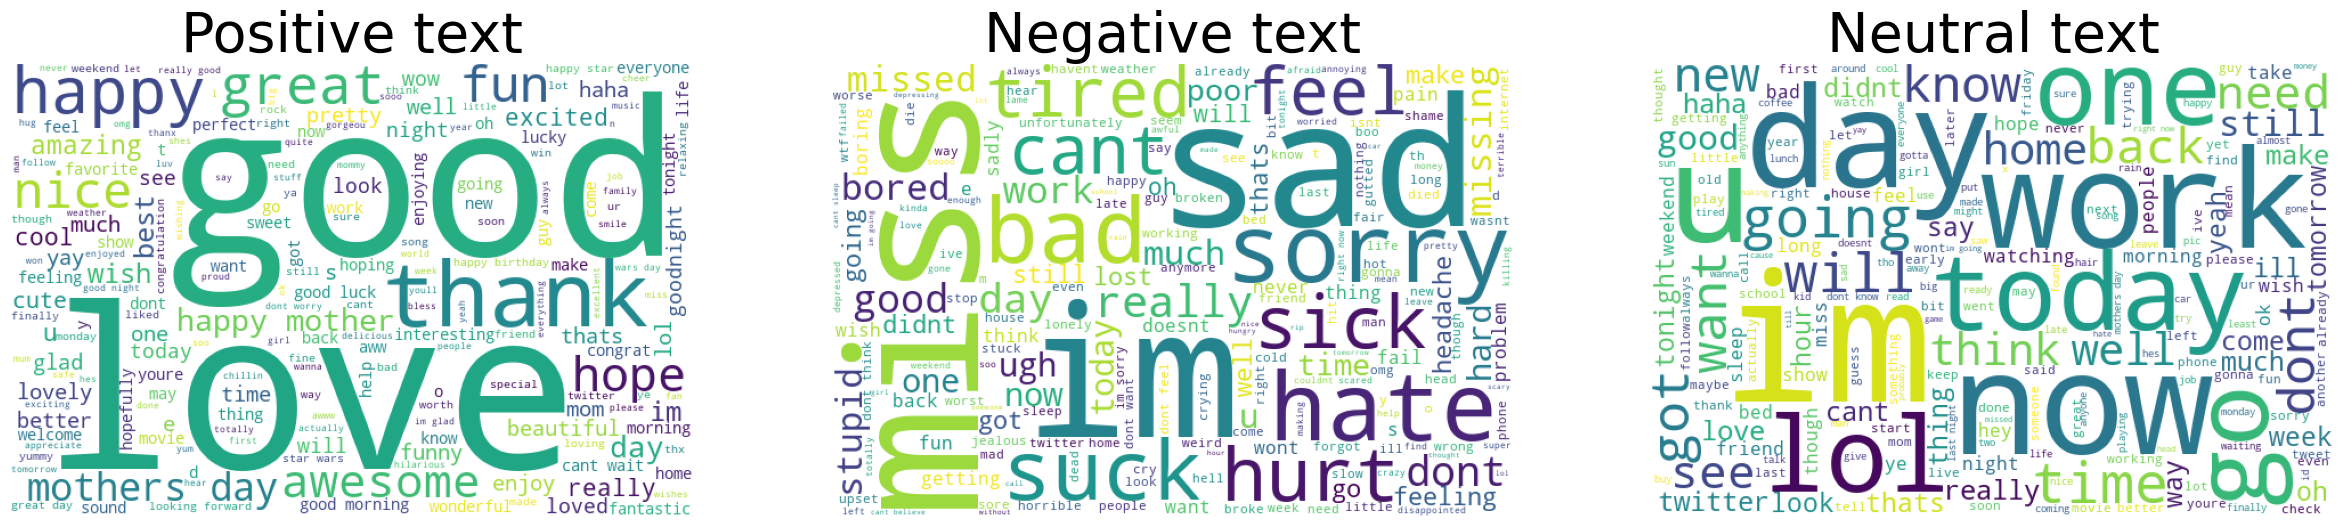

In [33]:
from wordcloud import WordCloud
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text_clean))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive text',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text_clean))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative text',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text_clean))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral text',fontsize=40);


The wordclouds give an idea of the words which might influence the polarity of the tweet.

<b>Modeling using NER:</b> Now we will use NER for sentiment extraction

In [45]:
df_train = pd.read_csv('twitter_sentiment_analysis/train.csv')
df_test = pd.read_csv('twitter_sentiment_analysis/test.csv')
df_submission = pd.read_csv('twitter_sentiment_analysis/submission.csv')

In [46]:
#Number of words in main text in train set
df_train['Num_words_text'] = df_train['text'].apply(lambda x:len(str(x).split())) 

In [47]:
df_train = df_train[df_train['Num_words_text']>=3]

In [54]:
#creating function to save model to given output directory

def save_model(output_dir, nlp, new_model_name):
    
    output_dir = f'twitter_sentiment_analysis/working/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [55]:
#training on top of existing model 

def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
    
    # add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        # sizes = compounding(1.0, 4.0, 1.001)
        # batch up the examples using spaCy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts,  # batch of texts
                            annotations,  # batch of annotations
                            drop=0.5,   # dropout - make it harder to memorise data
                            losses=losses, 
                            )
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [56]:
# Returns Model output path

def get_model_out_path(sentiment):
    
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'models/model_neg'
    return model_out_path

In [57]:
#Returns Trainong data in the format needed to train spacy NER

def get_training_data(sentiment):
    train_data = []
    for index, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

In [65]:
#training model for positive tweets
sentiment = 'positive'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)
# training 3 iterations of the model
train(train_data, model_path, n_iter=3, model=None)

Created blank 'en' model


 33%|███▎      | 1/3 [01:00<02:01, 60.56s/it]

Losses {'ner': 33496.53556535622}


 67%|██████▋   | 2/3 [01:55<00:58, 58.75s/it]

Losses {'ner': 31337.83527730761}


100%|██████████| 3/3 [02:48<00:00, 56.25s/it]

Losses {'ner': 29282.358906720343}
Saved model to ../working/models/model_pos


In [66]:
#training model for positive tweets
sentiment = 'negative'
train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=3, model=None)

Created blank 'en' model


 33%|███▎      | 1/3 [00:51<01:42, 51.48s/it]

Losses {'ner': 32154.324267990654}


 67%|██████▋   | 2/3 [01:42<00:51, 51.28s/it]

Losses {'ner': 28447.33843526055}


100%|██████████| 3/3 [02:32<00:00, 50.78s/it]

Losses {'ner': 27092.111071065432}
Saved model to ../working/models/model_neg


In [68]:
selected_texts = []
Models_Base_path = '../input/models/models/'

if Models_Base_path is not None:
    print("Loading Models  from ", Models_Base_path)
    model_pos = spacy.load(Models_Base_path + 'model_pos')
    model_neg = spacy.load(Models_Base_path + 'model_neg')
        
    for index, row in df_test.iterrows():
        text = row.text
        output_str = ""
        if row.sentiment == 'neutral' or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == 'positive':
            selected_texts.append(predict_entities(text, model_pos))
        else:
            selected_texts.append(predict_entities(text, model_neg))

Loading Models  from  ../input/models/models/


In [69]:
df_submission['selected_text'] = df_test['selected_text']
df_submission.to_csv("submission.csv", index=False)
display(df_submission.head(10))

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Good tweeps in China: (SH) (BJ).
2,eee518ae67,shame!
3,01082688c6,happy bday!
4,33987a8ee5,I like it!!
5,726e501993,that`s great!! weee!! visitors!
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol
7,afa11da83f,"soooooo wish i could, but im in school and my..."
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...
